In [1]:
import os
import csv
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation
from scipy.integrate import trapz

In [2]:
data_directory = "./IMU_Recordings"
file_names = ["01IMU.csv", "02IMU.csv", "03IMU.csv", "04IMU.csv", "05IMU.csv", "06IMU.csv", "07IMU.csv", "08IMU.csv", "09IMU.csv", "10IMU.csv", "11IMU.csv", "12IMU.csv", "13IMU.csv", "14IMU.csv", "15IMU.csv", "16IMU.csv", "17IMU.csv", "18IMU.csv"]
person_names = ["p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13", "p14", "p15", "p16", "p17", "p18"]

# Initialize dictionaries to store DataArrays for each person
acc_dict = {}
gyr_dict = {}
quat_dict = {}
time_dict = {}

In [3]:
for file_name, person_name in zip(file_names, person_names):
    # Construct the full path to the dataset file
    file_path = os.path.join(data_directory, file_name)

    # Load the dataset
    data = pd.read_csv(file_path)

    # Extract acceleration, quaternion, and time data from the dataset
    acc = np.array([data['Acc_X'], data['Acc_Y'], data['Acc_Z']])
    q = np.array([data['Quat_X'], data['Quat_Y'], data['Quat_Z'], data['Quat_W']])
    gyr = np.array([data['Gyr_X'], data['Gyr_Y'], data['Gyr_Z']])
    # Create a time array starting from 0 increasing by 1
    time = np.arange(len(data['SampleTimeFine']))

    # Reshape the quaternion array to have each quaternion as a row
    reshaped_q = np.transpose(q)

    # Convert to DataArrays
    acc_x = xr.DataArray(acc[0], dims=('time',), coords={'time': time})
    acc_y = xr.DataArray(acc[1], dims=('time',), coords={'time': time})
    acc_z = xr.DataArray(acc[2], dims=('time',), coords={'time': time})

    gyr_x = xr.DataArray(gyr[0], dims=('time',), coords={'time': time})
    gyr_y = xr.DataArray(gyr[1], dims=('time',), coords={'time': time})
    gyr_z = xr.DataArray(gyr[2], dims=('time',), coords={'time': time})

    quat_x = xr.DataArray(q[0], dims=('time',), coords={'time': time})
    quat_y = xr.DataArray(q[1], dims=('time',), coords={'time': time})
    quat_z = xr.DataArray(q[2], dims=('time',), coords={'time': time})
    quat_w = xr.DataArray(q[3], dims=('time',), coords={'time': time})

    # Store DataArrays in dictionaries
    acc_dict[person_name] = xr.Dataset({'acc_x': acc_x, 'acc_y': acc_y, 'acc_z': acc_z})
    gyr_dict[person_name] = xr.Dataset({'gyr_x': gyr_x, 'gyr_y': gyr_y, 'gyr_z': gyr_z})
    quat_dict[person_name] = reshaped_q
    time_dict[person_name] = time

# Gravity Compensation

In [4]:
# Initialize a dictionary to store reshaped acceleration data
reshaped_acc_dict = {}
reshaped_gyr_dict = {}

# Iterate over each person's dataset
for person_name, acc_dataset in acc_dict.items():
    reshaped_acc = np.array([acc_dataset['acc_x'], acc_dataset['acc_y'], acc_dataset['acc_z']])
    reshaped_acc = np.transpose(reshaped_acc)
    reshaped_acc_dict[person_name] = reshaped_acc

for person_name, gyr_dataset in gyr_dict.items():
    reshaped_gyr = np.array([gyr_dataset['gyr_x'], gyr_dataset['gyr_y'], gyr_dataset['gyr_z']])
    reshaped_gyr = np.transpose(reshaped_gyr)
    reshaped_gyr_dict[person_name] = reshaped_gyr

In [5]:
# Gravitation as array [x, y, z]
g = np.array([0, 0, 9.81])

# Iterate over each person's quaternion dataset
for person_name, quat_data in quat_dict.items():
    acc_data = reshaped_acc_dict[person_name]
    gyr_data = reshaped_gyr_dict[person_name]
    num_samples = quat_data.shape[0]
    
    # Initialize array to store global acceleration for the current person
    acc_global = np.zeros((num_samples, 3))
    gyr_global = np.zeros((num_samples, 3))
    
    # Rotate to global frame and subtract g for acceleration
    for i in range(num_samples):
        r = Rotation.from_quat(quat_data[i]).as_matrix()
        acc_global[i] = np.dot(r, acc_data[i]) - g
        gyr_global[i] = np.dot(r, gyr_data[i])
    
    time = time_dict[person_name]
    
    acc_x_global = xr.DataArray(acc_global[:, 0], dims=('time',), coords={'time': time})
    acc_y_global = xr.DataArray(acc_global[:, 1], dims=('time',), coords={'time': time})
    acc_z_global = xr.DataArray(acc_global[:, 2], dims=('time',), coords={'time': time})
    gyr_x_global = xr.DataArray(gyr_global[:, 0], dims=('time',), coords={'time': time})
    gyr_y_global = xr.DataArray(gyr_global[:, 1], dims=('time',), coords={'time': time})
    gyr_z_global = xr.DataArray(gyr_global[:, 2], dims=('time',), coords={'time': time})
    
    # Add global acceleration DataArray objects to acc_dict
    acc_dict[person_name]['acc_x_global'] = acc_x_global
    acc_dict[person_name]['acc_y_global'] = acc_y_global
    acc_dict[person_name]['acc_z_global'] = acc_z_global
    gyr_dict[person_name]['gyr_x_global'] = gyr_x_global
    gyr_dict[person_name]['gyr_y_global'] = gyr_y_global
    gyr_dict[person_name]['gyr_z_global'] = gyr_z_global

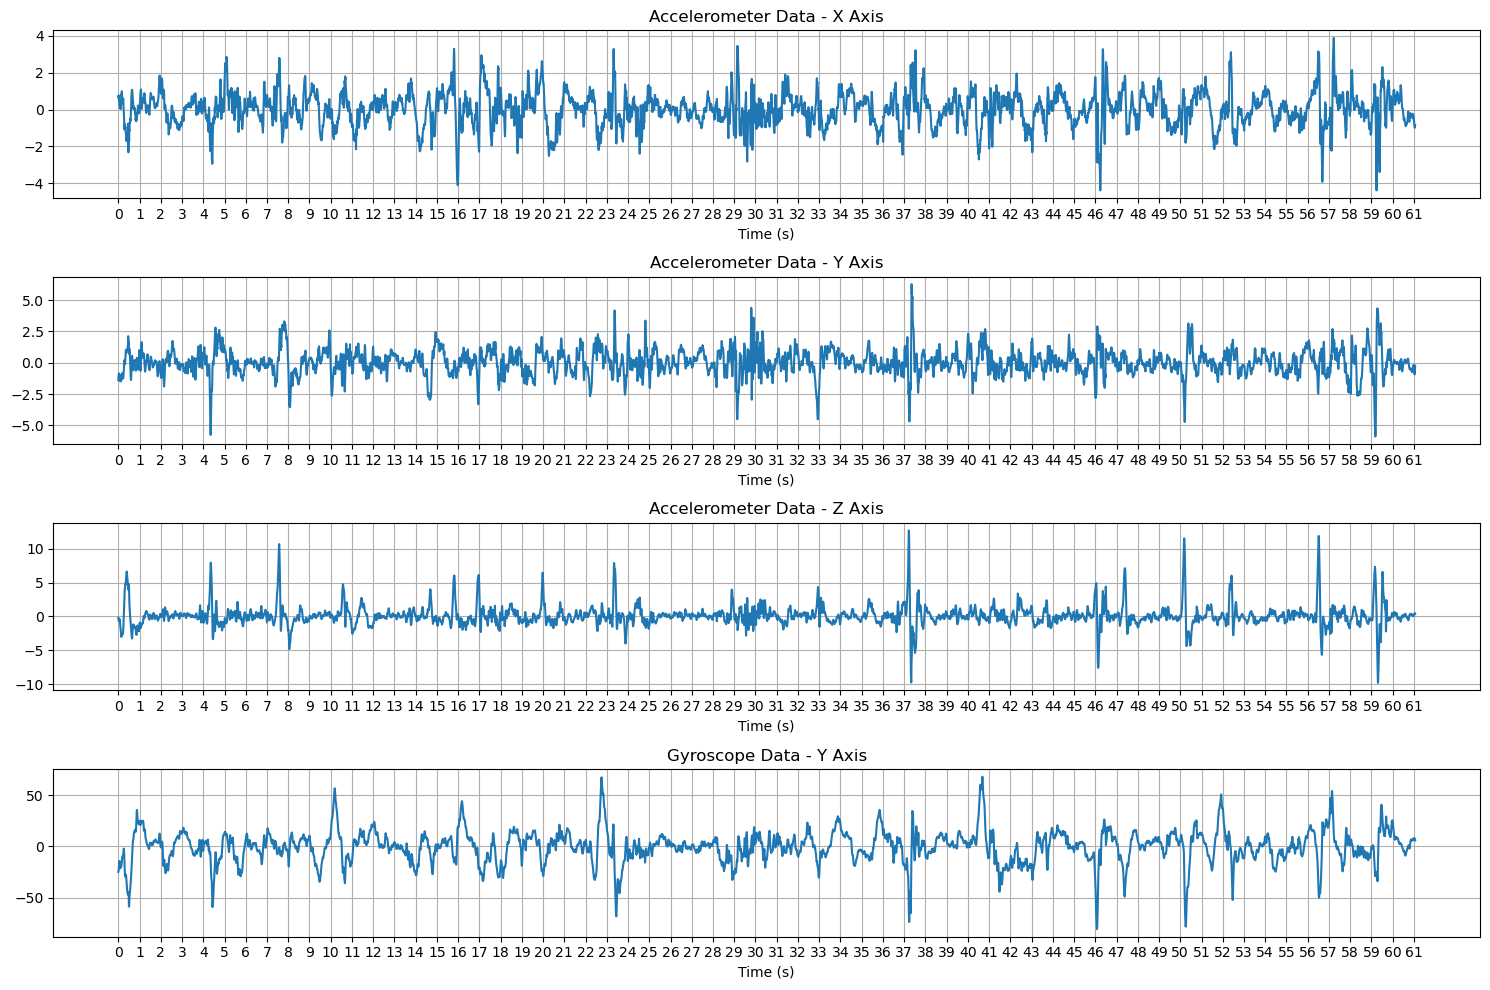

In [28]:
# Assuming acc_dict is your dictionary containing accelerometer data
person_name = 'p1'
# p1,8,11
# 12, 14

# Extract accelerometer data for the person
acc_x_global = acc_dict[person_name]['acc_x_global']
acc_y_global = acc_dict[person_name]['acc_y_global']
acc_z_global = acc_dict[person_name]['acc_z_global']
gyr_x_global = gyr_dict[person_name]['gyr_x_global']
gyr_y_global = gyr_dict[person_name]['gyr_y_global']
gyr_z_global = gyr_dict[person_name]['gyr_z_global']

# Cut the first 9 * 120 data samples
cut_samples_begin = 1
cut_samples_end = 1
acc_x_global_cut = acc_x_global[cut_samples_begin:-cut_samples_end]
acc_y_global_cut = acc_y_global[cut_samples_begin:-cut_samples_end]
acc_z_global_cut = acc_z_global[cut_samples_begin:-cut_samples_end]
gyr_x_global_cut = gyr_x_global[cut_samples_begin:-cut_samples_end]
gyr_y_global_cut = gyr_y_global[cut_samples_begin:-cut_samples_end]
gyr_z_global_cut = gyr_z_global[cut_samples_begin:-cut_samples_end]

# Create a time axis
time = np.arange(len(acc_x_global_cut)) / 120  # Dividing by 120 to convert to seconds

# Create a figure and three subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 10))

# Plot data for X axis
axes[0].plot(time, acc_x_global_cut, label='X Axis')
axes[0].set_title('Accelerometer Data - X Axis')
axes[0].set_xlabel('Time (s)')
axes[0].set_xticks(np.arange(0, max(time), 1))  # Adjust the second parameter to control the spacing between ticks
axes[0].grid(True)

# Plot data for Y axis
axes[1].plot(time, acc_y_global_cut, label='Y Axis')
axes[1].set_title('Accelerometer Data - Y Axis')
axes[1].set_xlabel('Time (s)')
axes[1].set_xticks(np.arange(0, max(time), 1))  # Adjust the second parameter to control the spacing between ticks
axes[1].grid(True)

# Plot data for Z axis
axes[2].plot(time, acc_z_global_cut, label='Z Axis')
axes[2].set_title('Accelerometer Data - Z Axis')
axes[2].set_xlabel('Time (s)')
axes[2].set_xticks(np.arange(0, max(time), 1))  # Adjust the second parameter to control the spacing between ticks
axes[2].grid(True)

axes[3].plot(time, gyr_y_global_cut, label='Y Axis')
axes[3].set_title('Gyroscope Data - Y Axis')
axes[3].set_xlabel('Time (s)')
axes[3].set_xticks(np.arange(0, max(time), 1))  # Adjust the second parameter to control the spacing between ticks
axes[3].grid(True)

# Adjust layout and display plot
plt.tight_layout()
plt.show()



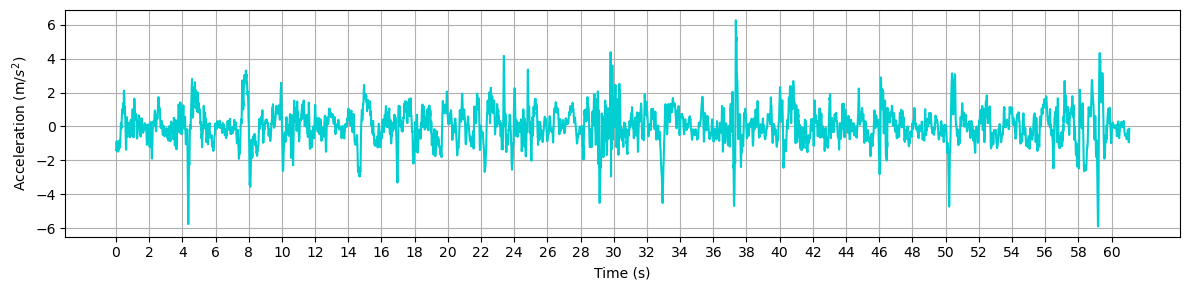

In [48]:
person_name = 'p1'
acc_y_global = acc_dict[person_name]['acc_y_global']

# Create a time axis
time = np.arange(len(acc_y_global)) / 120  # Dividing by 120 to convert to seconds

plt.figure(figsize=(12, 3))
plt.plot(time, acc_y_global, label='Y Axis', color='darkturquoise')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/$s^2$)')
plt.xticks(np.arange(0, max(time), 2))  # Adjust the second parameter to control the spacing between ticks
plt.grid(True)
plt.tight_layout()
plt.show()

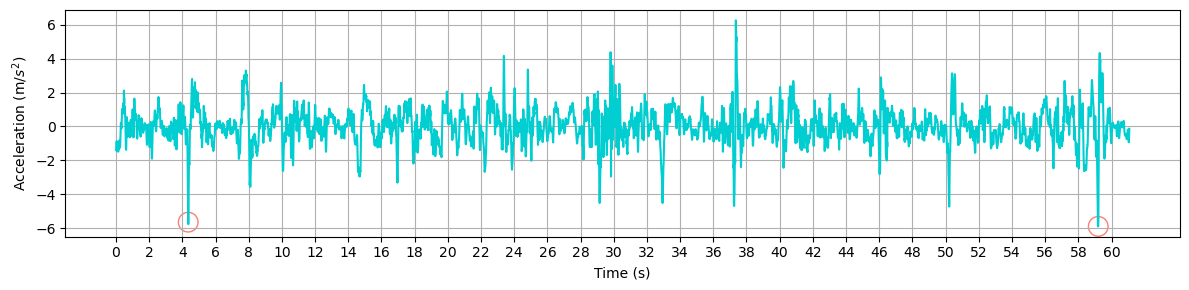

In [67]:
import numpy as np
import matplotlib.pyplot as plt

person_name = 'p1'
acc_y_global = acc_dict[person_name]['acc_y_global']

# Create a time axis
time = np.arange(len(acc_y_global)) / 120  # Dividing by 120 to convert to seconds


plt.figure(figsize=(12, 3))
plt.plot(time, acc_y_global, label='Y Axis', color='darkturquoise')

# Adding the red oval at 4 seconds
plt.scatter(4.35, -5.65, color='salmon', edgecolor='salmon', s=200, facecolors='none')
plt.scatter(59.2, -5.9, color='salmon', edgecolor='salmon', s=200, facecolors='none')

plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/$s^2$)')
plt.xticks(np.arange(0, max(time), 2))  # Adjust the second parameter to control the spacing between ticks
plt.grid(True)
plt.tight_layout()
plt.show()


# Save cut Data

In [7]:
acc_dict[person_name]['acc_x_global_cut'] = acc_x_global[cut_samples_begin:-cut_samples_end]
acc_dict[person_name]['acc_y_global_cut'] = acc_y_global[cut_samples_begin:-cut_samples_end]
acc_dict[person_name]['acc_z_global_cut'] = acc_z_global[cut_samples_begin:-cut_samples_end]
gyr_dict[person_name]['gyr_x_global_cut'] = gyr_x_global[cut_samples_begin:-cut_samples_end]
gyr_dict[person_name]['gyr_y_global_cut'] = gyr_y_global[cut_samples_begin:-cut_samples_end]
gyr_dict[person_name]['gyr_z_global_cut'] = gyr_z_global[cut_samples_begin:-cut_samples_end]

In [8]:
print(acc_dict['p2'])

<xarray.Dataset>
Dimensions:           (time: 9395)
Coordinates:
  * time              (time) int32 0 1 2 3 4 5 ... 9389 9390 9391 9392 9393 9394
Data variables:
    acc_x             (time) float64 12.25 11.08 9.925 ... 10.11 10.13 10.15
    acc_y             (time) float64 -4.671 -3.87 -3.176 ... 0.05019 0.05507
    acc_z             (time) float64 2.05 2.062 2.256 ... -1.899 -2.207 -2.429
    acc_x_global      (time) float64 2.921 2.467 2.194 ... -1.079 -1.08 -1.122
    acc_y_global      (time) float64 -1.634 -1.668 -1.844 ... 0.9743 1.239 1.411
    acc_z_global      (time) float64 3.03 1.726 0.4595 ... 0.3718 0.4235 0.4679
    acc_x_global_cut  (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    acc_y_global_cut  (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    acc_z_global_cut  (time) float64 nan nan nan nan nan ... nan nan nan nan nan


In [9]:
# Iterate over each person's data
for person_name in acc_dict.keys():
    # Create a new file for the current person
    file_name = f"data_cut_{person_name}.csv"
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the header row
        writer.writerow(['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z'])

        # Extract data for the current person
        acc_x = acc_dict[person_name]['acc_x_global_cut']
        acc_y = acc_dict[person_name]['acc_y_global_cut']
        acc_z = acc_dict[person_name]['acc_z_global_cut']
        gyr_x = gyr_dict[person_name]['gyr_x_global_cut']
        gyr_y = gyr_dict[person_name]['gyr_y_global_cut']
        gyr_z = gyr_dict[person_name]['gyr_z_global_cut']

        # Ensure all data lists have the same length
        min_len = min(len(acc_x), len(acc_y), len(acc_z), len(gyr_x), len(gyr_y), len(gyr_z))

        # Write data rows
        for i in range(min_len):
            writer.writerow([acc_x[i], acc_y[i], acc_z[i], gyr_x[i], gyr_y[i], gyr_z[i]])

    print(f"Data for {person_name} has been saved to {file_name}")





KeyError: 'acc_x_global_cut'